# **Modelo Regresión Lineal para Proyecto de deforestación**

**Curso: 09481 - Inteligencia Artificial.**

**Universidad Icesi.**

**Profesor: Breyner Posso.**

**Estudiantes: Nicolas Colmenares, Nicolas Penagos, Juan Guapacha,Juan Pablo Sanin**

**Introducción**

En este enfoque del proyecto buscamos complementar el modelo basado en imágenes
a través de un dataset de deforestación en el Amazonas.

Para este trabajo se apoyó en recursos brindados por el profesor Breyner Posso y un proyecto de Salma B en Kaggle (https://www.kaggle.com/code/sbengali/brazilian-amazon-rainforest-degradation-analysis)

También se tuvo en cuenta el análisis exploratorio inicial a el dataset realizado en el la primera entrega del proyecto (https://colab.research.google.com/drive/17kdCZDov4ZNSWX57-aPcWJlLX150uf1h#scrollTo=2fCttZG0opEs)

Para la segunda iteración avanzamos desarrollando el modelo de regresión entre incendios y deforestación obtenido en la segunda entrega del proyecto (https://colab.research.google.com/drive/1oUVdD9iu4eU9NjpCJwewQrrmpGa_yYIR#scrollTo=joPv14uMg95U)

Para este modelo se trabajaron con 2 archivos csv:
 
1.   Deforestación anual por regiones (def_area_2004_2019.csv)
2.   Incendios mensuales en región de 1999 a 2019 (inpe_brazilian_amazon_fires_1999_2019.csv)


**Resumen entrega final**

Para la entrega final se propuso generar datos a partir de la cantidad de puntos de incedios mensuales. Logrando generar datos de deforestación para los meses de los años dependiendo del porcentaje de incendios que se presentan en ese mes.

Luego, con mayor cantidad de datos se busca un modelo que supere las métricas de la entrega pasada:

- R2: 0.6952
- RMSE: 3267.5321


## Librerías

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
import plotly.express as px
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics



## Datasets

In [26]:
deforest_df = pd.read_csv('def_area_2004_2019.csv')
fires_df =  pd.read_csv('inpe_brazilian_amazon_fires_1999_2019.csv')

In [27]:
#En este primer data set se cuenta con el año y los kilometros cuadrados de deforestación por región
deforest_df.head()

,Ano/Estados,AC,AM,AP,MA,MT,PA,RO,RR,TO,AMZ LEGAL
0,2004,728,1232,46,755,11814,8870,3858,311,158,27772
1,2005,592,775,33,922,7145,5899,3244,133,271,19014
2,2006,398,788,30,674,4333,5659,2049,231,124,14286
3,2007,184,610,39,631,2678,5526,1611,309,63,11651
4,2008,254,604,100,1271,3258,5607,1136,574,107,12911


In [28]:
# Tenemos 16 filas que hacen referencia a los años del 2004 a 2019
deforest_df.shape

(16, 11)

In [29]:
'''
Para este dataset tenemos los meses de cada año, la región, sus coordenadas y 
la cantidad de incendios que se presentaron en ese mes
'''
fires_df.head()

,year,month,state,latitude,longitude,firespots
0,1999,1,AMAZONAS,-2.371113,-59.899933,3
1,1999,1,MARANHAO,-2.257395,-45.487831,36
2,1999,1,MATO GROSSO,-12.660633,-55.057989,18
3,1999,1,PARA,-2.474820,-48.546967,87
4,1999,1,RONDONIA,-12.861700,-60.513100,1


In [30]:
# Tenemos 2104 registros desde 1999 a 2019
fires_df.shape

(2104, 6)

## Limpieza y exploración dataset deforestación

In [31]:
# Limpieza y cambio de nombres
deforest_df.drop(['AMZ LEGAL'], axis=1, inplace=True)
deforest_df.rename(columns={'Ano/Estados': 'Year',
                            'AC':'Acre', 
                            'AM':'Amazonas',
                            'AP':'Amapa', 
                            'MA':'Maranhao', 
                            'MT':'Mato Grosso', 
                            'PA':'Para',
                            'RO':'Rondonia', 
                            'RR':'Roraima', 
                            'TO':'Tocantins'}
                            , inplace=True)
deforest_df.head()

,Year,Acre,Amazonas,Amapa,Maranhao,Mato Grosso,Para,Rondonia,Roraima,Tocantins
0,2004,728,1232,46,755,11814,8870,3858,311,158
1,2005,592,775,33,922,7145,5899,3244,133,271
2,2006,398,788,30,674,4333,5659,2049,231,124
3,2007,184,610,39,631,2678,5526,1611,309,63
4,2008,254,604,100,1271,3258,5607,1136,574,107


In [32]:
#Agregamos columna con deforestación total
deforest_df['total_area'] = (deforest_df['Acre'] + 
                             deforest_df['Amazonas'] + 
                             deforest_df['Amapa'] + 
                             deforest_df['Maranhao'] + 
                             deforest_df['Mato Grosso'] + 
                             deforest_df['Para'] + 
                             deforest_df['Rondonia'] + 
                             deforest_df['Roraima'] + 
                             deforest_df['Tocantins'])
deforest_df.head()

,Year,Acre,Amazonas,Amapa,Maranhao,Mato Grosso,Para,Rondonia,Roraima,Tocantins,total_area
0,2004,728,1232,46,755,11814,8870,3858,311,158,27772
1,2005,592,775,33,922,7145,5899,3244,133,271,19014
2,2006,398,788,30,674,4333,5659,2049,231,124,14286
3,2007,184,610,39,631,2678,5526,1611,309,63,11651
4,2008,254,604,100,1271,3258,5607,1136,574,107,12911


## Limpieza y expansión dataset deforestación

In [33]:
#Agregamos mayúsculas a las regiones
fires_df.state = [x.capitalize() for x in fires_df.state]

#agregamos meses
months= {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep',
             10:'Oct', 11:'Nov', 12:'Dec'}
fires_df['month_str'] = fires_df['month'].map(months)

fires_df.head()

,year,month,state,latitude,longitude,firespots,month_str
0,1999,1,Amazonas,-2.371113,-59.899933,3,Jan
1,1999,1,Maranhao,-2.257395,-45.487831,36,Jan
2,1999,1,Mato grosso,-12.660633,-55.057989,18,Jan
3,1999,1,Para,-2.474820,-48.546967,87,Jan
4,1999,1,Rondonia,-12.861700,-60.513100,1,Jan


**Gráfico incendios por mes en total**

Aquí logramos ver que se presentan mayor cantidad de incendios en la segunda mitad del año que en la primera. A partir de esta información se decide segmentar los totales de deforestación a partir de los porcentajes de incendios por mes.

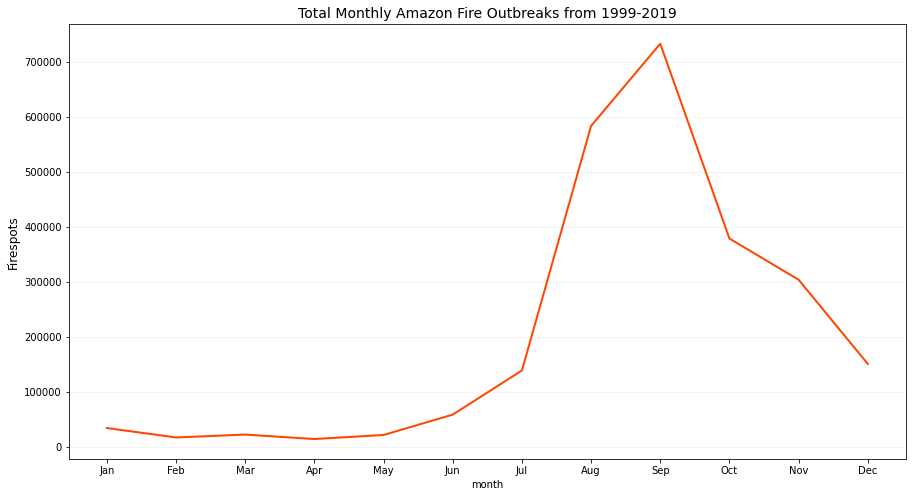

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
months_piv = pd.pivot_table(fires_df, values='firespots',index=['month'], aggfunc=np.sum, fill_value=0)
months_piv.plot(xticks=range(1,13,1), linewidth=2, color='orangered', legend=False, ax=ax)
ax.set_ylabel('Firespots', fontsize=12)
ax.set_title('Total Monthly Amazon Fire Outbreaks from 1999-2019', fontsize=14)
ax.set_xticklabels(months.values())
ax.grid(axis='y', color='0.95')
plt.show()

#Creación de dataset incendios y deforestación mensual 2004-2019

**Limpiamos los datasets:**

En el ambos eliminamos las zonas y en el de incendios ajustamos los años eliminando datos desde 1999 a 2004


In [34]:
# Limpieza de zonas deforest
deforest_df.drop(deforest_df.iloc[:, 1:10], axis=1, inplace=True)
deforest_df.head()

,Year,total_area
0,2004,27772
1,2005,19014
2,2006,14286
3,2007,11651
4,2008,12911


In [35]:
# Limpieza de zonas incendios
fires_df.drop(fires_df.iloc[:, 2:5], axis=1, inplace=True)
fires_df = fires_df[fires_df['year'] >= 2004]
fires_df.head()

,year,month,firespots,month_str
455,2004,1,58,Jan
456,2004,1,277,Jan
457,2004,1,242,Jan
458,2004,1,171,Jan
459,2004,1,875,Jan


In [64]:
#Suma de incendios por mes
#Pivoteamos el dataset 
totals_df = pd.pivot_table(fires_df, values='firespots',index=['year'], 
                     aggfunc=np.sum, fill_value=0)
totals_df.reset_index(level=['year'], inplace=True)

#Agregamos total de deforestación
totals_df['total_area'] = deforest_df['total_area'].values

#Total de incendios y deforestación
totals_df.head()

,year,firespots,total_area
0,2004,218637,27772
1,2005,213720,19014
2,2006,144422,14286
3,2007,186480,11651
4,2008,103453,12911


In [75]:
#Generamos dataset con incendios por mes
fires_piv = pd.pivot_table(fires_df, values='firespots',index=['year','month'],
                     aggfunc=np.sum, fill_value=0)
fires_piv.rename(index=months,inplace=True)

fires_piv.reset_index(level=['year', 'month'], inplace=True)
fires_piv.head()

,year,month,firespots
0,2004,Jan,2178
1,2004,Feb,805
2,2004,Mar,1035
3,2004,Apr,1012
4,2004,May,3131


In [ ]:
#Agregar totales al dataframe para manipularlo
year_firespots= pd.Series(totals_df.firespots.values,index=totals_df.year).to_dict()
year_deforest= pd.Series(totals_df.total_area.values,index=totals_df.year).to_dict()


fires_piv['total_firespots'] = fires_piv['year'].map(year_firespots)
fires_piv['total_area'] = fires_piv['year'].map(year_deforest)
fires_piv

In [79]:
# Ahora debemos implementar la formula: (firespots/total_firespots)*total_area
# De esta manera obtenemos la deforestación relacionada en porcentaje a ese mes de incendios
fires_piv['area'] = (fires_piv['firespots']/fires_piv['total_firespots'])*fires_piv['total_area']
fires_piv

,year,month,firespots,total_firespots,total_area,area
0,2004,Jan,2178,218637,27772,276.656815
1,2004,Feb,805,218637,27772,102.253781
2,2004,Mar,1035,218637,27772,131.469147
3,2004,Apr,1012,218637,27772,128.547611
4,2004,May,3131,218637,27772,397.710049
...,...,...,...,...,...,...
187,2019,Aug,30900,88135,9762,3422.542690
188,2019,Sep,19925,88135,9762,2206.930845
189,2019,Oct,7855,88135,9762,870.034719
190,2019,Nov,11297,88135,9762,1251.277177


In [81]:
#Revisamos que las sumas esten bien
check_df=fires_piv.groupby(['year']).sum()
check_df.head()

,firespots,total_firespots,total_area,area
year,,,,
2004,218637,2623644,333264,27772.0
2005,213720,2564640,228168,19014.0
2006,144422,1733064,171432,14286.0
2007,186480,2237760,139812,11651.0
2008,103453,1241436,154932,12911.0


In [85]:
#reordenamos el dataframe
final_df = fires_piv[['year', 'month', 'firespots', 'area', 'total_firespots','total_area']]
final_df

,year,month,firespots,area,total_firespots,total_area
0,2004,Jan,2178,276.656815,218637,27772
1,2004,Feb,805,102.253781,218637,27772
2,2004,Mar,1035,131.469147,218637,27772
3,2004,Apr,1012,128.547611,218637,27772
4,2004,May,3131,397.710049,218637,27772
...,...,...,...,...,...,...
187,2019,Aug,30900,3422.542690,88135,9762
188,2019,Sep,19925,2206.930845,88135,9762
189,2019,Oct,7855,870.034719,88135,9762
190,2019,Nov,11297,1251.277177,88135,9762


Luego de este proceso logramos ampliar la cantidad de datos de 16 registros a 192, lo cual nos da un mayor volumen para nuestro modelo de regresión.

In [86]:
final_df.shape

(192, 6)

## Desarrollo de modelos

### Regresión lineal

In [103]:
# Definimos entradas y salidas
from sklearn.linear_model import LinearRegression
lin_reg_1 = LinearRegression()
y = final_df['area'].values
x = final_df['firespots'].values
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [104]:
#partición de datos
mezclar_los_datos       = True 
valor_semilla_aleatoria = 42   

#Porcentajes de división de datos. 
particion_para_entrenamiento = 0.6  #Dejamos el 60% de los datos para el conjunto de entrenamiento (training set).
particion_para_validacion    = 0.2  #Dejamos el 20% de los datos para el conjunto de desarrollo (dev set).
                                    #Este conjunto se conoce también como: selección del modelo, validación, o hold-out.
particion_para_entrenamiento_y_validacion = particion_para_entrenamiento+particion_para_validacion #Variable auxiliar. 
particion_para_pruebas       = 1.0-particion_para_entrenamiento_y_validacion #Dejamos los otros datos, correspondiente al 20%, para el conjunto de pruebas. 

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
x_rest, x_test, y_rest, y_test = train_test_split(x,                                         #100% de los datos de entrada. 
                                                  y,                                         #100% de los datos de salida. 
                                                  test_size=particion_para_pruebas, 
                                                  random_state=valor_semilla_aleatoria, 
                                                  shuffle=mezclar_los_datos)

#Del "resto" obtenemos los conjuntos de entrenamiento y desarrollo. 
x_train, x_val, y_train, y_val = train_test_split(x_rest,                                    #Una fracción de los datos de entrada. 
                                                  y_rest,                                    #Una fracción de los datos de salida.        
                                                  test_size=particion_para_validacion/particion_para_entrenamiento_y_validacion, #cuidado! este es el porcentaje respecto al "resto". 
                                                  random_state=valor_semilla_aleatoria, 
                                                  shuffle=False) #Los datos ya se mezclaron arriba, no es necesario repetirlo acá.  

print('Conjunto de datos de entrenamiento {:1.0f}% = {} ejemplos.'.format(particion_para_entrenamiento*100,X_train.shape[0]))
print('Conjunto de datos de validación    {:1.0f}% = {} ejemplos.'.format(particion_para_validacion*100,X_val.shape[0]))
print('Conjunto de datos de prueba        {:1.0f}% = {} ejemplos.'.format(particion_para_pruebas*100,X_test.shape[0]))

Conjunto de datos de entrenamiento 60% = 114 ejemplos.
Conjunto de datos de validación    20% = 39 ejemplos.
Conjunto de datos de prueba        20% = 39 ejemplos.


In [105]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(x_train,y_train)

LinearRegression()

In [114]:
#Función para evaluar modelos:

def regressionEvaluator(x,y,y_pred,x_label, y_label, title):
 
  print("")
  print("----- "+title+" --------")
  print("")
  print('intercept [w0]=', lin_reg_model.intercept_)
  print('slope [wn]=', lin_reg_model.coef_)


  plt.scatter(x, y, label='Real')
  plt.plot(x,y_pred,'r', label='Predicted')
  plt.title(x_label+'VS'+y_label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

  r_sq = lin_reg_model.score(x, y)
  print('coefficient R^2 for '+title+' data: %.4f' % r_sq)
  print('coefficient R for '+title+' data: %.4f' % np.sqrt(r_sq))

  e_train = y - y_pred

  plt.scatter(y_pred,e_train)
  a = np.zeros(len(e_train))
  a = a.reshape(-1,1)
  plt.scatter(y_pred,a)
  plt.title(title+' Data: Residuals vs Predicted values')
  plt.ylabel('Residuals')
  plt.xlabel('Predicted')
  plt.show()

  mse = metrics.mean_squared_error(y, y_pred)
  rmse = np.sqrt(mse)
  print('MSE= %.4f'% mse)
  print('RMSE: %.4f' % rmse)


----- Training --------

intercept [w0]= [1.62994946]
slope [wn]= [[0.08710824]]


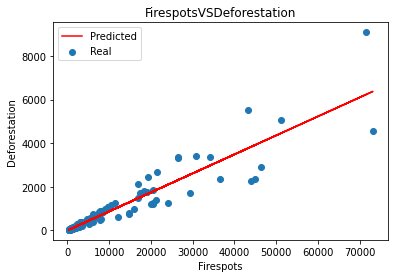

coefficient R^2 for Training data: 0.8524
coefficient R for Training data: 0.9233


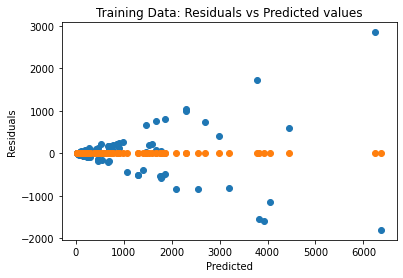

MSE= 266376.8095
RMSE: 516.1171


In [115]:
y_pred_train = lin_reg_model.predict(x_train)
regressionEvaluator(x_train,y_train,y_pred_train,"Firespots", "Deforestation", "Training")


----- Validation --------

intercept [w0]= [1.62994946]
slope [wn]= [[0.08710824]]


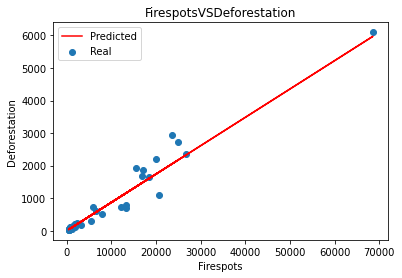

coefficient R^2 for Validation data: 0.9468
coefficient R for Validation data: 0.9730


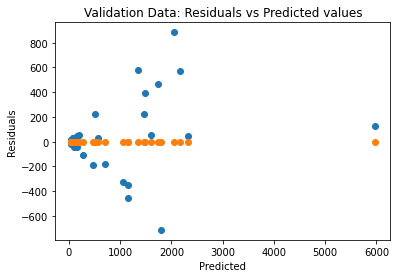

MSE= 76514.8991
RMSE: 276.6133


In [116]:
y_pred_val = lin_reg_model.predict(x_val)
regressionEvaluator(x_val,y_val,y_pred_val,"Firespots", "Deforestation", "Validation")

In [111]:
#Cross validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

lin_reg_2 = LinearRegression()

scores = cross_validate(lin_reg_2, x_rest, y_rest, cv=10, scoring=('neg_mean_squared_error','r2'))

mse_scores = abs(scores['test_neg_mean_squared_error'])
mse = mse_scores.mean()
rmse = np.sqrt(mse)
std_mse = mse_scores.std()
a = np.sqrt(mse_scores)
std_rmse = a.std()

r2_scores = abs(scores['test_r2'])
r2 = r2_scores.mean()
std_r2 = r2_scores.std()

print('R^2: %.4f'% r2)
print('Std MAE: %.4f'% std_r2)
print('RMSE: %.4f'% rmse)
print('Std RMSE: %.4f'% std_rmse)

R^2: 0.8223
Std MAE: 0.1610
RMSE: 503.2584
Std RMSE: 243.0730



----- Test --------

intercept [w0]= [1.62994946]
slope [wn]= [[0.08710824]]


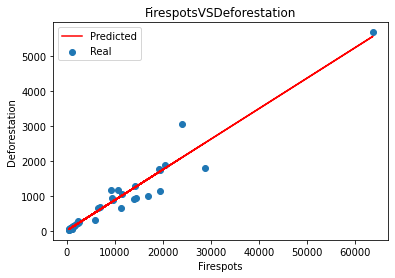

coefficient R^2 for Test data: 0.9394
coefficient R for Test data: 0.9692


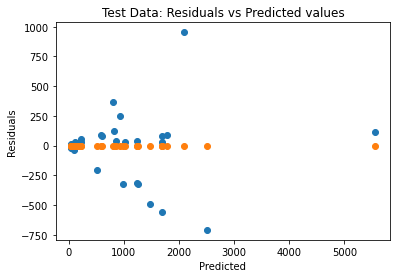

MSE= 66406.4596
RMSE: 257.6945


In [119]:
y_pred_test = lin_reg_model.predict(x_test)
regressionEvaluator(x_test,y_test,y_pred_test,"Firespots", "Deforestation", "Test")

In [124]:
#Exportamos el modelo para el despligue
import joblib

joblib.dump(lin_reg_model,"fires_area_model.joblib")

['fires_area_model.joblib']

In [130]:
print(joblib.__version__)

1.2.0


## Conclusiones

Para cerrar, al aumentar la cantidad de registros de 16 a 192 utilizando el porcentaje de la cantidad de puntos de incendios por mes se logra ver una mejora esperada. Obtuvimos un R2 de 0.85 para los datos de entrenamiento y posteriormente un excelente ajuste a los datos de validación y prueba con R2 de 0.94 y 0.93 respectivamente. En cuanto al RMSE que para el entrenamiento fue de 516 km2 nos deja algo de duda frente a las predicciones del modelo puesto que es un valor elevado encuanto a área deforestada y en comparación a los totales mensuales. Para validación y prueba el valor se rebaja a 276 km2 y 275 km2 respectivamente, lo cuál sigue siendo un área elevada, sin embargo podemos decir que el modelo mejoró significativamente pasando de 3267 km2 en el RMSE de la entrega anterior.

En ultimas instancias podemos afirmar que el modelo desarrollado a partir del dataset generado tiene métricas exitosas dentro de nuestro marco esperado. Generar mayor cantidad de registros acorde a los meses fue una decisión acertada y se evidencia en los resultados obtenidos. 

